In [1]:
#Michele Fullilove
#Python programming project
#Neurocognitive Methods and Programming
#SoSe 2021
#June 30, 2021

#Goal: Validating an image classification model for American Sign Language (ASL) manual signs using Machine Learning
 

#Copied and pasted code from DataCamp (https://projects.datacamp.com/projects/509) script (notebookASL.py) to import necessary libraries/modules and set random seeds; modified code as needed/indicated 
import numpy as np
np.random.seed(5) 
import tensorflow as tf
#tf.set_random_seed(2) #This line of code returned an error: AttributeError: module 'tensorflow' has no attribute 'set_random_seed'; modified code per instructions online; must have been written for older version of tensorflow
tf.random.set_seed(2)
#from datasets import sign_language #This line of code returned an error: ModuleNotFoundError: No module named 'datasets'
#"datasets" is the name of the folder on DataCamp containing the sign_language module and images
#downloaded module to hard drive and was able to import the module from there by omitting "from datasets"
#uploaded sign_language.py to jupyter notebook and able to run here
import sign_language
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

Task to solve: For a computer to recognize a static image of a manual sign and label the sign accurately to enable understanding by a non-signing individual.

Expected result: In the DataCamp notebook “ASL Recognition with Deep Learning”, a neural network was defined, trained, and tested to classify images using a dataset composed of photographs of manual signs or silhouettes of signs representing the letters A, B, or C. When first trained and tested, the model was able to classify the images with 92.75% accuracy.  We would expect the model to classify other similar images with about the same level of accuracy.  However, there are factors of the new dataset which may lead to reduced accuracy: the original dataset contained approximately 1000 images for each manual sign, while the new dataset is much smaller, consisting of only 30 of each manual sign; also, while the original data had a fairly blank background, the background for each manual sign in the new dataset has a much more noisy background, with other lines/patterns/shapes that may interfere with the classification of each image.    

In [2]:
#insert sign_language module code within body of main script; this module collects and shuffles the jpg images and converts them to numpy arrays which are pixel-by-pixel vectors containing values of red, blue, and green (RBG) per pixel
#the module divides the images into training and testing sets
# then the module changes the numpy arrays to PIL form for tensorflow to process
import random
import numpy as np
from keras.utils import np_utils, to_categorical
from keras.preprocessing import image
from os import listdir
from os.path import isdir, join

#Modified "container_path" from "datasets" to the path on my hard drive where the data was stored
def load_data(container_path='C:\\Users\\Asus\\Documents\\NCMProgram_wArtTimo\\datasets', folders=['A', 'B', 'C'],
              size=2000, test_split=0.2, seed=0):
    """
    Loads sign language dataset.
    """
    
    filenames, labels = [], []

    for label, folder in enumerate(folders):
        folder_path = join(container_path, folder)
        images = [join(folder_path, d)
                     for d in sorted(listdir(folder_path))]
        labels.extend(len(images) * [label])
        filenames.extend(images)
    
    random.seed(seed)
    data = list(zip(filenames, labels))
    random.shuffle(data)
    data = data[:size]
    filenames, labels = zip(*data)

    
    # Get the images
    x = paths_to_tensor(filenames).astype('float32')/255
    # Store the one-hot targets
    y = np.array(labels)

    x_train = np.array(x[:int(len(x) * (1 - test_split))])
    y_train = np.array(y[:int(len(x) * (1 - test_split))])
    x_test = np.array(x[int(len(x) * (1 - test_split)):])
    y_test = np.array(y[int(len(x) * (1 - test_split)):])

    return (x_train, y_train), (x_test, y_test)


def path_to_tensor(img_path, size):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(size, size))
    # convert PIL.Image.Image type to 3D tensor
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor 
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths, size=50):
    list_of_tensors = [path_to_tensor(img_path, size) for img_path in img_paths]
    return np.vstack(list_of_tensors)




In [3]:
#needed to modify the code from DataCamp to direct to my files to upload the data
import os
os.chdir('C:\\Users\\Asus\\Documents\\NCMProgram_wArtTimo')
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
(x_train, y_train), (x_test, y_test) = sign_language.load_data()

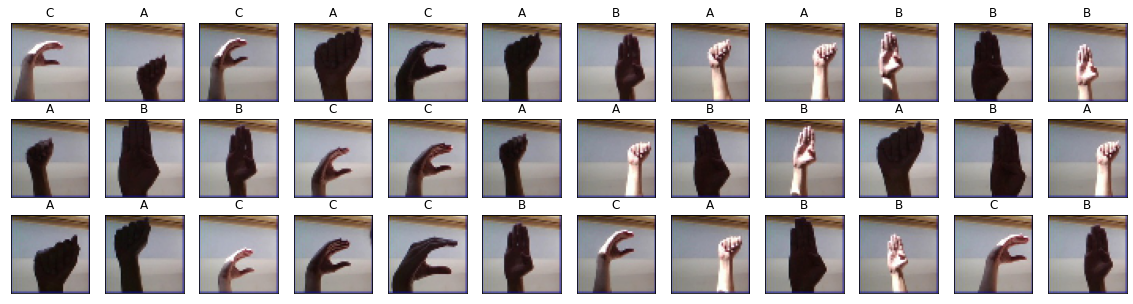

In [4]:
#Code from DataCamp to show a sample of the dataset
# Store labels of dataset
labels = ['A', 'B', 'C']
# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20,5))
for i in range(36):
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_train[i]))
    ax.set_title("{}".format(labels[y_train[i]]))
plt.show()


The above for loop displayed a sample of 3 rows of 12 images from the training portion of the dataset with their associated labels

The following code counts the number of each type of image in the training and testing sets and prints the amounts to confirm that there are equivalent numbers of each

In [5]:
# Number of A's in the training dataset
num_A_train = sum(y_train==0)
# Number of B's in the training dataset
num_B_train = sum(y_train==1)
# Number of C's in the training dataset
num_C_train = sum(y_train==2)

# Number of A's in the test dataset
num_A_test = sum(y_test==0)
# Number of B's in the test dataset
num_B_test = sum(y_test==1)
# Number of C's in the test dataset
num_C_test = sum(y_test==2)

# Print statistics about the dataset
print("Training set:")
print("\tA: {}, B: {}, C: {}".format(num_A_train, num_B_train, num_C_train))
print("Test set:")
print("\tA: {}, B: {}, C: {}".format(num_A_test, num_B_test, num_C_test))


Training set:
	A: 540, B: 528, C: 532
Test set:
	A: 118, B: 144, C: 138


There are roughly 500+ of each letter in the training set and about 100+ of each in the test set

In order for keras to be able to process the data it needs to be "one-hot encoded", or converted into zeroes and ones.

In [6]:
from keras.utils import np_utils

# One-hot encode the training labels
y_train_OH = np_utils.to_categorical(y_train, 3)

# One-hot encode the test labels
y_test_OH = np_utils.to_categorical(y_test, 3)

The following code uses keras to define, compile, and train a model, a convolutional neural network, to classify the images.  I completed the DataCamp courses necessary to understand more about how these work (Introduction to Deep Learning in Python and Image Processing with Keras in Python).

In [7]:
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense
from keras.models import Sequential

model = Sequential()
# First convolutional layer accepts image input
model.add(Conv2D(filters=5, kernel_size=5, padding='same', activation='relu', 
                        input_shape=(50, 50, 3)))
# Add a max pooling layer
model.add(MaxPooling2D(pool_size=4))
# Add a convolutional layer
model.add(Conv2D(filters=15, kernel_size=5, padding='same', activation='relu'))
# Add another max pooling layer
model.add(MaxPooling2D(pool_size=4))
# Flatten and feed to output layer
model.add(Flatten())
model.add(Dense(3, activation='softmax'))






In [8]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 5)         380       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 15)        1890      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 15)          0         
_________________________________________________________________
flatten (Flatten)            (None, 135)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 408       
Total params: 2,678
Trainable params: 2,678
Non-trainable params: 0
______________________________________________________

The output of the summary shows the various levels/layers of the model.

In [9]:
# ## 6. Compile the model
# <p>After we have defined a neural network in Keras, the next step is to compile it! </p>

# In[ ]:


# Compile the model
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [10]:
# ## 7. Train the model
# <p>Once we have compiled the model, we're ready to fit it to the training data.</p>

# In[ ]:


# Train the model
hist = model.fit(x_train, y_train_OH,
                 validation_split=0.2,
                 epochs=2,
                 batch_size=32)

Epoch 1/2
40/40 [==============================] - 1s 35ms/step - loss: 0.9851 - accuracy: 0.5734 - val_loss: 0.7859 - val_accuracy: 0.7063
Epoch 2/2
40/40 [==============================] - 1s 28ms/step - loss: 0.6937 - accuracy: 0.7430 - val_loss: 0.5391 - val_accuracy: 0.8562


The output above showed the training procedure through 2 epochs, or training rounds, with accuracy improving from 70% to 85%.

In [11]:
# ## 8. Test the model
# <p>To evaluate the model, we'll use the test dataset.  This will tell us how the network performs when classifying images it has never seen before!</p>
# <p>If the classification accuracy on the test dataset is similar to the training dataset, this is a good sign that the model did not overfit to the training data.  </p>

# In[ ]:


# Obtain accuracy on test set
score = model.evaluate(x=x_test, 
                       y=y_test_OH,
                       verbose=0)
print('Test accuracy:', score[1])


Test accuracy: 0.8399999737739563


The model classified the test images with about 84% accuracy, which is close to the value of the training set (85%), suggesting that the model did not overfit to the training data.  The code below displays the errors with the incorrect label provided by the model as well as the correct label. 

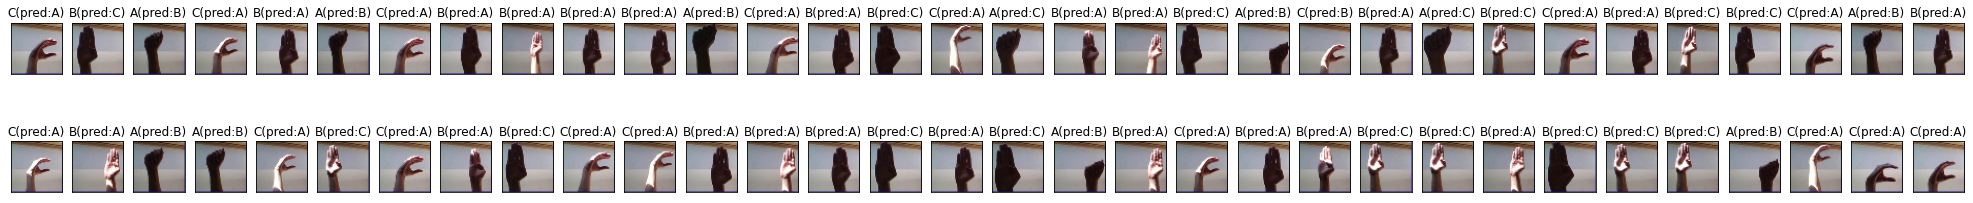

In [12]:
# ## 9. Visualize mistakes
# <p>Hooray!  Our network gets very high accuracy on the test set!  </p>
# <p>The final step is to take a look at the images that were incorrectly classified by the model.  Do any of the mislabeled images look relatively difficult to classify, even to the human eye?  </p>
# <p>Sometimes, it's possible to review the images to discover special characteristics that are confusing to the model.  However, it is also often the case that it's hard to interpret what the model had in mind!</p>

# In[ ]:


# Get predicted probabilities for test dataset
y_probs = model.predict(x_test)

# Get predicted labels for test dataset
y_preds = np.argmax(y_probs, axis=1)

# Indices corresponding to test images which were mislabeled
bad_test_idxs = np.where(y_preds!=y_test)[0]

fig = plt.figure(figsize=(35,4))
for i, idx in enumerate(bad_test_idxs):
    ax = fig.add_subplot(2, int(np.ceil(len(bad_test_idxs))/2), i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    ax.set_title("{}(pred:{})".format(labels[y_test[idx]], labels[y_preds[idx]]))

In above code, this line: "ax = fig.add_subplot(2, np.ceil(len(bad_test_idxs)/2), i + 1, xticks=[], yticks=[])" was causing an error so was changed as follows:
ax = fig.add_subplot(2, int(np.ceil(len(bad_test_idxs))/2), i + 1, xticks=[], yticks=[])
per suggestion online, that the code expected an integer and was instead being passed a float type value so wrapped "np.ceil...idxs" inside "int()".

Also the following lines: "fig = plt.figure(figsize=(25,4))....ax.set_title("{} (pred: {})".format(labels[y_test[idx]], labels[y_preds[idx]]))" was printing the titles for the images overlapping each other, so was modified as follows:
"fig = plt.figure(figsize=(35,4))....ax.set_title("{}(pred:{})".format(labels[y_test[idx]], labels[y_preds[idx]]))"
(changed size from 25 to 35 and removed spaces front the title).

After training and testing the model with the original dataset from DataCamp, the model was validated using a new dataset obtained from https://www.kaggle.com/grassknoted/asl-alphabet, consisting of 30 images for each of the 26 letters of the alphabet each with various backgrounds, from which images representing a set of three signs (A, B, C) will be chosen to create training and testing data sets.  Given an image of a particular sign, the model should be able to correctly label/sort the corresponding letter.  

In a separate notebook, the model is constructed in a similar manner using the code from DataCamp, modifying as necessary to upload the new dataset.

Initially, I trained and tested the model on the original dataset in DataCamp and then started a new notebook to train and test the new dataset on the model in its original form.  After reviewing the DataCamp course "Introduction to Deep Learning in Python", I realized that it was possible to save a model after you've trained it and reload the trained model to use on the new dataset.  The following section of code is from this course.  

In [13]:
#code from DataCamp
from keras.models import load_model
#save trained model in .h5 format as "ASL_classifier"
model.save('ASL_classifier.h5')



In [15]:
load_model('ASL_classifier.h5')
new_model = load_model('ASL_classifier.h5')
predictions = new_model.predict('C:\Users\Asus\Documents\NCMProgram_wArtTimo\new_images')

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (<ipython-input-15-80e0bbc3d55e>, line 3)